In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import cv2
import random
from tqdm import notebook
from multiprocessing import Pool
from PIL import Image
import imageio

from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
import keras.backend as K
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.model_selection import train_test_split
print("No error found")

No error found


Using TensorFlow backend.


In [4]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
N_CLASSES = 13
BATCH_SIZE = 32
EPOCHS = 100
print("No error found")

No error found


# Prepare dataset

In [5]:
src_dir = '../input/lyft-udacity-challenge'
print("No error found")

No error found


In [6]:
input_imgs_names = []
mask_names = []
limit_per_class = 100

for i in ['A', 'B', 'C', 'D', 'E']:
    input_imgs = glob.glob(os.path.join(src_dir, f'data{i}/data*/CameraRGB/*.png'))
    masks = glob.glob(os.path.join(src_dir, f'data{i}/data*/CameraSeg/*.png'))
    
    # Select only the first 100 images and masks
    input_imgs_names += input_imgs[:limit_per_class]
    mask_names += masks[:limit_per_class]

num_samples = len(mask_names)

train_imgs, val_imgs, train_masks, val_masks = train_test_split(input_imgs_names, mask_names, train_size=0.8, random_state=0) 
print(f"Number of samples = {num_samples}")

Number of samples = 500


In [7]:
# Function to transform a 2D segmentation mask image into a 3D array, where each channel corresponds to one of the 13 classes.
def split_img(mask_img):    
    new_mask_img = np.zeros((mask_img.shape[0], mask_img.shape[1], 13))
    
    for j in range(13):
        for k in range(mask_img.shape[0]):
            for l in range(mask_img.shape[1]):
                if mask_img[k,l,2] == j:
                    new_mask_img[k,l,j] = j
    return new_mask_img



def give_color_to_seg_img(seg, n_classes=N_CLASSES):
    seg_img = np.zeros( (seg.shape[0],seg.shape[1], 3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

print("Executed")

Executed


(-0.5, 799.5, 599.5, -0.5)

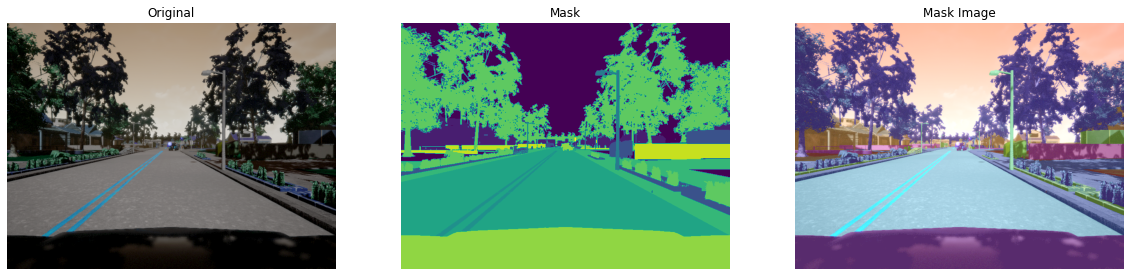

In [8]:
index = random.randint(0, num_samples-1)

img = cv2.imread(input_imgs_names[index])
mask = cv2.imread(mask_names[index])[:, :, 2]
mask_color = give_color_to_seg_img(mask)

plt.figure(figsize=(20, 6))
plt.subplot(131)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

plt.subplot(132)
plt.imshow(mask)
plt.title('Mask')
plt.axis('off')

plt.subplot(133)
plt.imshow(img / 255. + mask_color * 0.5)
plt.title('Mask Image')
plt.axis('off')

In [9]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_filenames,
                 mask_filenames,
                 batch_size=BATCH_SIZE,
                 shuffle=True):

        self.img_filenames = img_filenames
        self.mask_filenames = mask_filenames
        self.filenames = list(zip(img_filenames, mask_filenames))
        self.batch_size = BATCH_SIZE
        self.shuffle= shuffle
        self.n = len(self.img_filenames)

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)

    def __get_data(self, batches):
        imgs=[]
        segs=[]
        for img_file, mask_file in batches:
            image = cv2.imread(img_file)
            image = cv2.resize(image, (WIDTH, HEIGHT))
            image = image / 255.
            
            mask = cv2.imread(mask_file)
            mask = cv2.resize(mask, (WIDTH, HEIGHT))[:, :, 2]

            imgs.append(image)
            segs.append(mask)

        return np.array(imgs), np.array(segs)
    
    def __getitem__(self, index):

        batches = self.filenames[index * self.batch_size:(index + 1) * self.batch_size]

        X, y = self.__get_data(batches)

        return (X, y)

    def __len__(self):

        return self.n // self.batch_size

In [10]:
train_gen = DataGenerator(train_imgs, train_masks)
val_gen = DataGenerator(val_imgs, val_masks)
print("Executed")

Executed


In [11]:
for x, y in train_gen:
    break
x.shape, y.shape

((32, 256, 256, 3), (32, 256, 256))

Executed


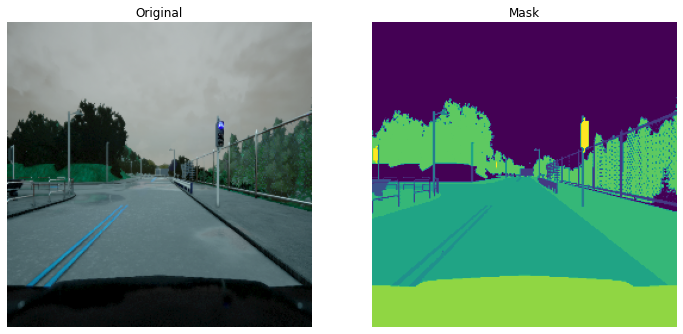

In [12]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(x[0])
plt.title('Original')
plt.axis('off')

plt.subplot(122)
plt.imshow(y[0])
plt.title('Mask')
plt.axis('off')
print("Executed")

In [13]:
def UNet():

    main_input = Input(shape=(HEIGHT, WIDTH, CHANNELS), name = 'img_input')

    ''' ~~~~~~~~~~~~~~~~~~~ ENCODING LAYERS ~~~~~~~~~~~~~~~~~~~ '''

    c1 = Conv2D(32, kernel_size=(3,3), padding = 'same')(main_input)
    c1 = LeakyReLU(0.2)(c1)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(32, kernel_size=(3,3), padding = 'same')(c1)
    c1 = LeakyReLU(0.2)(c1)
    c1 = BatchNormalization()(c1)

    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32*2, kernel_size=(3,3), padding = 'same')(p1)
    c2 = LeakyReLU(0.2)(c2)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(32*2, kernel_size=(3,3), padding = 'same')(c2)
    c2 = LeakyReLU(0.2)(c2)
    c2 = BatchNormalization()(c2)

    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(32*4, kernel_size=(3,3), padding = 'same')(p2)
    c3 = LeakyReLU(0.2)(c3)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(32*2, kernel_size=(1,1), padding = 'same')(c3)
    c3 = LeakyReLU(0.2)(c3)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(32*4, kernel_size=(3,3), padding = 'same')(c3)
    c3 = LeakyReLU(0.2)(c3)
    c3 = BatchNormalization()(c3)

    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(32*6, kernel_size=(3,3), padding = 'same')(p3)
    c4 = LeakyReLU(0.2)(c4)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(32*4, kernel_size=(1,1), padding = 'same')(c4)
    c4 = LeakyReLU(0.2)(c4)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(32*6, kernel_size=(3,3), padding = 'same')(c4)
    c4 = LeakyReLU(0.2)(c4)
    c4 = BatchNormalization()(c4)

    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(32*6, kernel_size=(3,3), padding = 'same')(p4)
    c5 = LeakyReLU(0.2)(c5)
    c5 = BatchNormalization()(c5)


    ''' ~~~~~~~~~~~~~~~~~~~ DECODING LAYERS ~~~~~~~~~~~~~~~~~~~ '''

    u1 = UpSampling2D((2,2))(c5)
    concat1 = concatenate([c4, u1])

    c6 = Conv2D(32*4, kernel_size=(3,3), padding = 'same')(concat1)
    c6 = LeakyReLU(0.2)(c6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(32*4, kernel_size=(3,3), padding = 'same')(c6)
    c6 = LeakyReLU(0.2)(c6)
    c6 = BatchNormalization()(c6)


    u2 = UpSampling2D((2,2))(c6)
    concat2 = concatenate([c3, u2])

    c7 = Conv2D(32*2, kernel_size=(3,3), padding = 'same')(concat2)
    c7 = LeakyReLU(0.2)(c7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(32*2, kernel_size=(3,3), padding = 'same')(c7)
    c7 = LeakyReLU(0.2)(c7)
    c7 = BatchNormalization()(c7)

    u3 = UpSampling2D((2,2))(c7)
    concat3 = concatenate([c2, u3])

    c8 = Conv2D(32, kernel_size=(3,3), padding = 'same')(concat3)
    c8 = LeakyReLU(0.2)(c8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(32, kernel_size=(3,3), padding = 'same')(c8)
    c8 = LeakyReLU(0.2)(c8)
    c8 = BatchNormalization()(c8)

    u4 = UpSampling2D((2,2))(c8)
    concat4 = concatenate([c1, u4])

    c9 = Conv2D(16, kernel_size = (1,1), padding = 'same')(concat4)
    c9 = LeakyReLU(0.2)(c9)
    c9 = BatchNormalization()(c9)

    mask_out = Conv2D(13, (1,1), padding = 'same', activation = 'sigmoid', name = 'mask_out')(c9)

    model = Model(inputs = [main_input], outputs = [mask_out])
    
    return model

In [14]:
model = UNet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         img_input[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         leaky_re_lu[0][0]                
______________________________________________________________________________________________

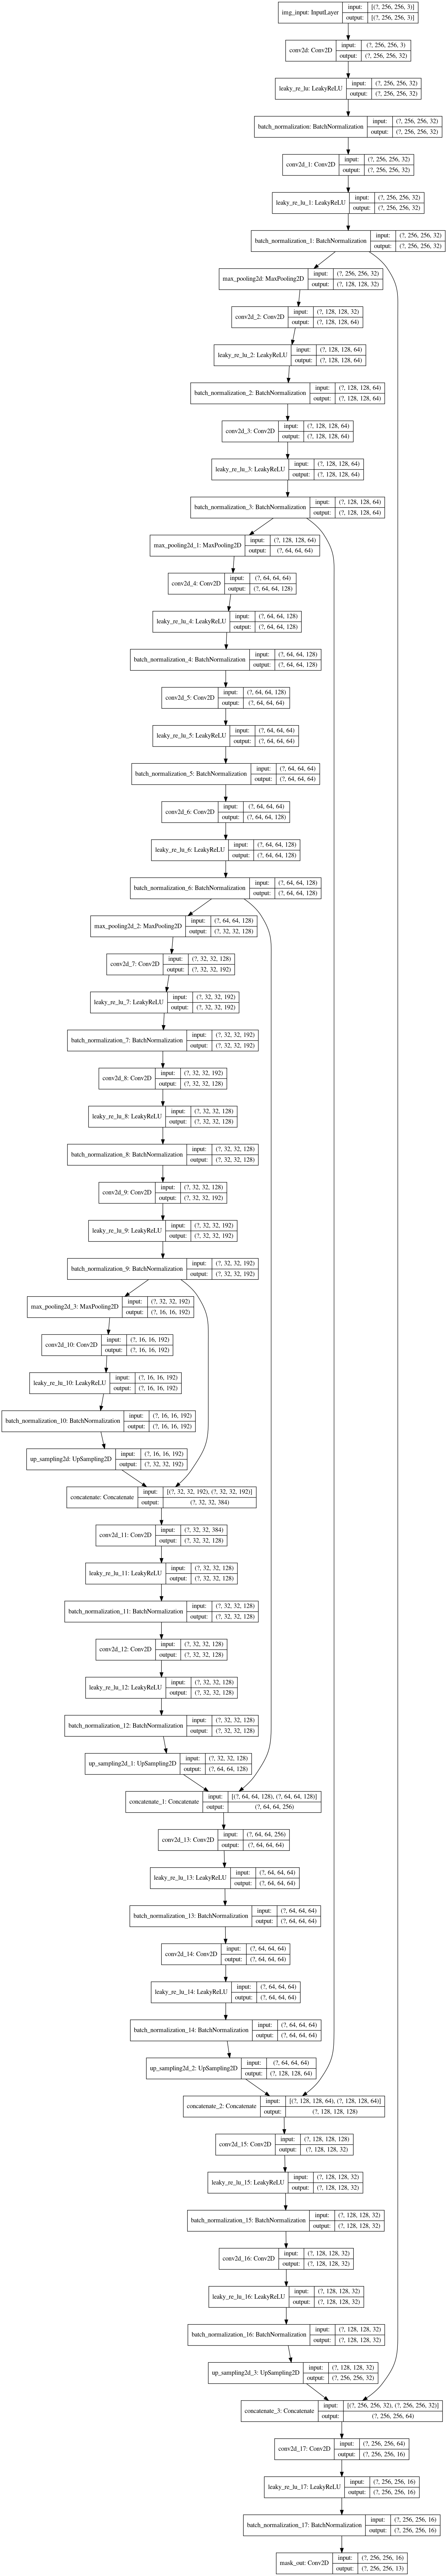

In [15]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Training

In [16]:
def lrfn(epoch):
    if epoch > 4:
        return 2e-4
    elif epoch > 8:
        return 1e-4
    return 1e-3

print("Executed")

Executed


In [17]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
print("Executed")

Executed


In [18]:
# Learning rate callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: lrfn(step))
# Model checkpoint, saves weights if val loss reduces
checkpoint =tf.keras.callbacks.ModelCheckpoint('model.h5', 'val_loss', save_best_only=True, save_weights_only=True, verbose=1)
print("Executed")

Executed


In [19]:
train_steps = len(train_gen)
val_steps = len(val_gen)

history = model.fit(train_gen, validation_data=val_gen, 
                    steps_per_epoch=train_steps, validation_steps=val_steps, 
                    epochs = 10, verbose=1, callbacks=[checkpoint, lr_callback])

# print("Executed")

Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 2.1647 - accuracy: 0.5560 
Epoch 00001: val_loss improved from inf to 2.53403, saving model to model.h5
12/12 [==============================] - 213s 18s/step - loss: 2.1647 - accuracy: 0.5560 - val_loss: 2.5340 - val_accuracy: 0.3196 - lr: 0.0010
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 1.9919 - accuracy: 0.7696 
Epoch 00002: val_loss improved from 2.53403 to 2.47627, saving model to model.h5
12/12 [==============================] - 210s 17s/step - loss: 1.9919 - accuracy: 0.7696 - val_loss: 2.4763 - val_accuracy: 0.4809 - lr: 0.0010
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 1.9190 - accuracy: 0.7917 
Epoch 00003: val_loss improved from 2.47627 to 2.36683, saving model to model.h5
12/12 [==============================] - 211s 18s/step - loss: 1.9190 - accuracy: 0.7917 - val_loss: 2.3668 - val_accuracy: 0.5242 - lr: 0.0010
Epoch 4/10
12/12 [==========================

# Training history

Executed


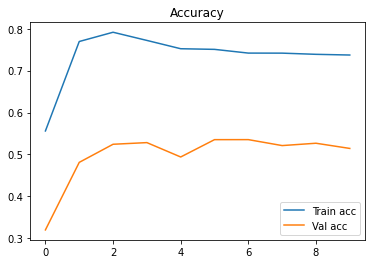

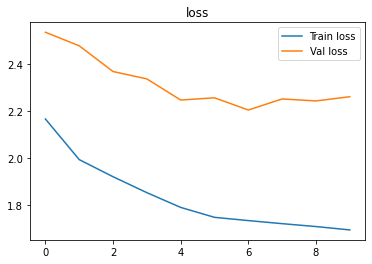

In [20]:
plt.figure()
plt.plot(history.history['accuracy'], label = 'Train acc')
plt.plot(history.history['val_accuracy'], label = 'Val acc')
plt.title('Accuracy')
plt.legend()

plt.figure()
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Val loss')
plt.title('loss')
plt.legend()
print("Executed")

# Validations

In [21]:
model.save_weights('lastest.h5')
model.load_weights('model.h5')
print("Executed")

Executed


In [22]:
test_gen = DataGenerator(val_imgs, val_masks, 1)
print("executed")

executed


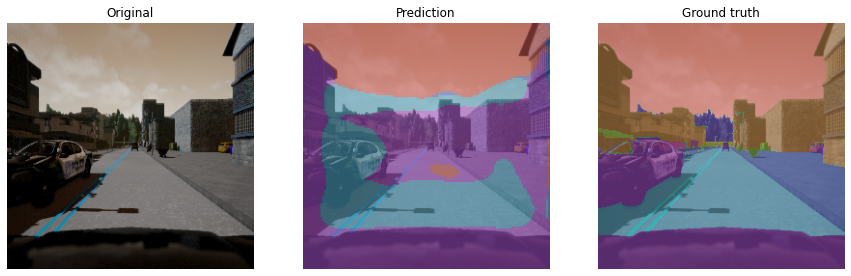

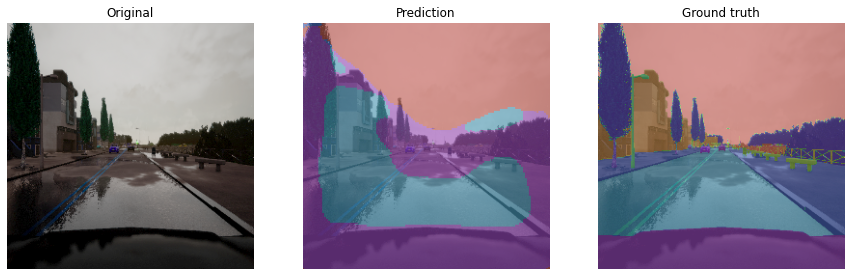

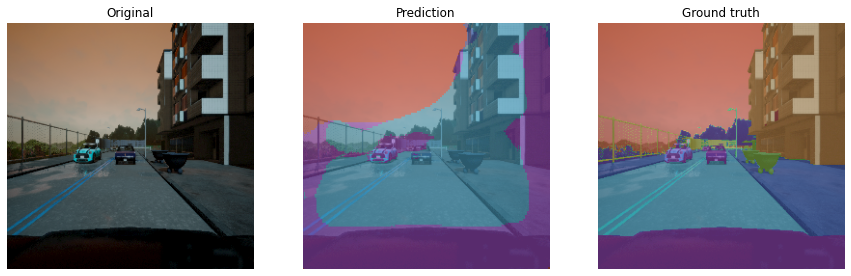

Executed


In [23]:
max_show = 3
test_iter = iter(test_gen)
for i in range(max_show):
    images, masks = next(test_iter)
    mask_color = give_color_to_seg_img(masks[0])

    preds = model.predict(images)
    pred_masks = np.argmax(preds, axis = 3)
    pred_mask_color = give_color_to_seg_img(pred_masks[0])
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))
    
    for a in ax:
        a.axis('off')

    ax[0].imshow(images[0])
    ax[0].set_title('Original')
    
    ax[1].imshow(images[0] * 0.5 + pred_mask_color * 0.5)
    ax[1].set_title('Prediction')
    
    ax[2].imshow(images[0] * 0.5 + mask_color * 0.5)
    ax[2].set_title('Ground truth')
    plt.savefig(f"pred_{i}.jpg", dpi=150)
    plt.show()
    
print("Executed")